In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import datetime
import matplotlib.pyplot as plt

from vmdpy import VMD
from scipy.signal import savgol_filter
from keras.models import Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Conv1D, MaxPooling1D, MultiHeadAttention, BatchNormalization, Concatenate, Layer, GlobalAveragePooling1D, Multiply, Reshape
from keras.callbacks import TensorBoard, EarlyStopping
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# dirs
DATA_DIR = "./load.csv"

In [4]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')
data['Load'] = data['Load'] * 4


In [5]:
# scaler
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
# data['Load'] = data_scaled

(10, 35040)


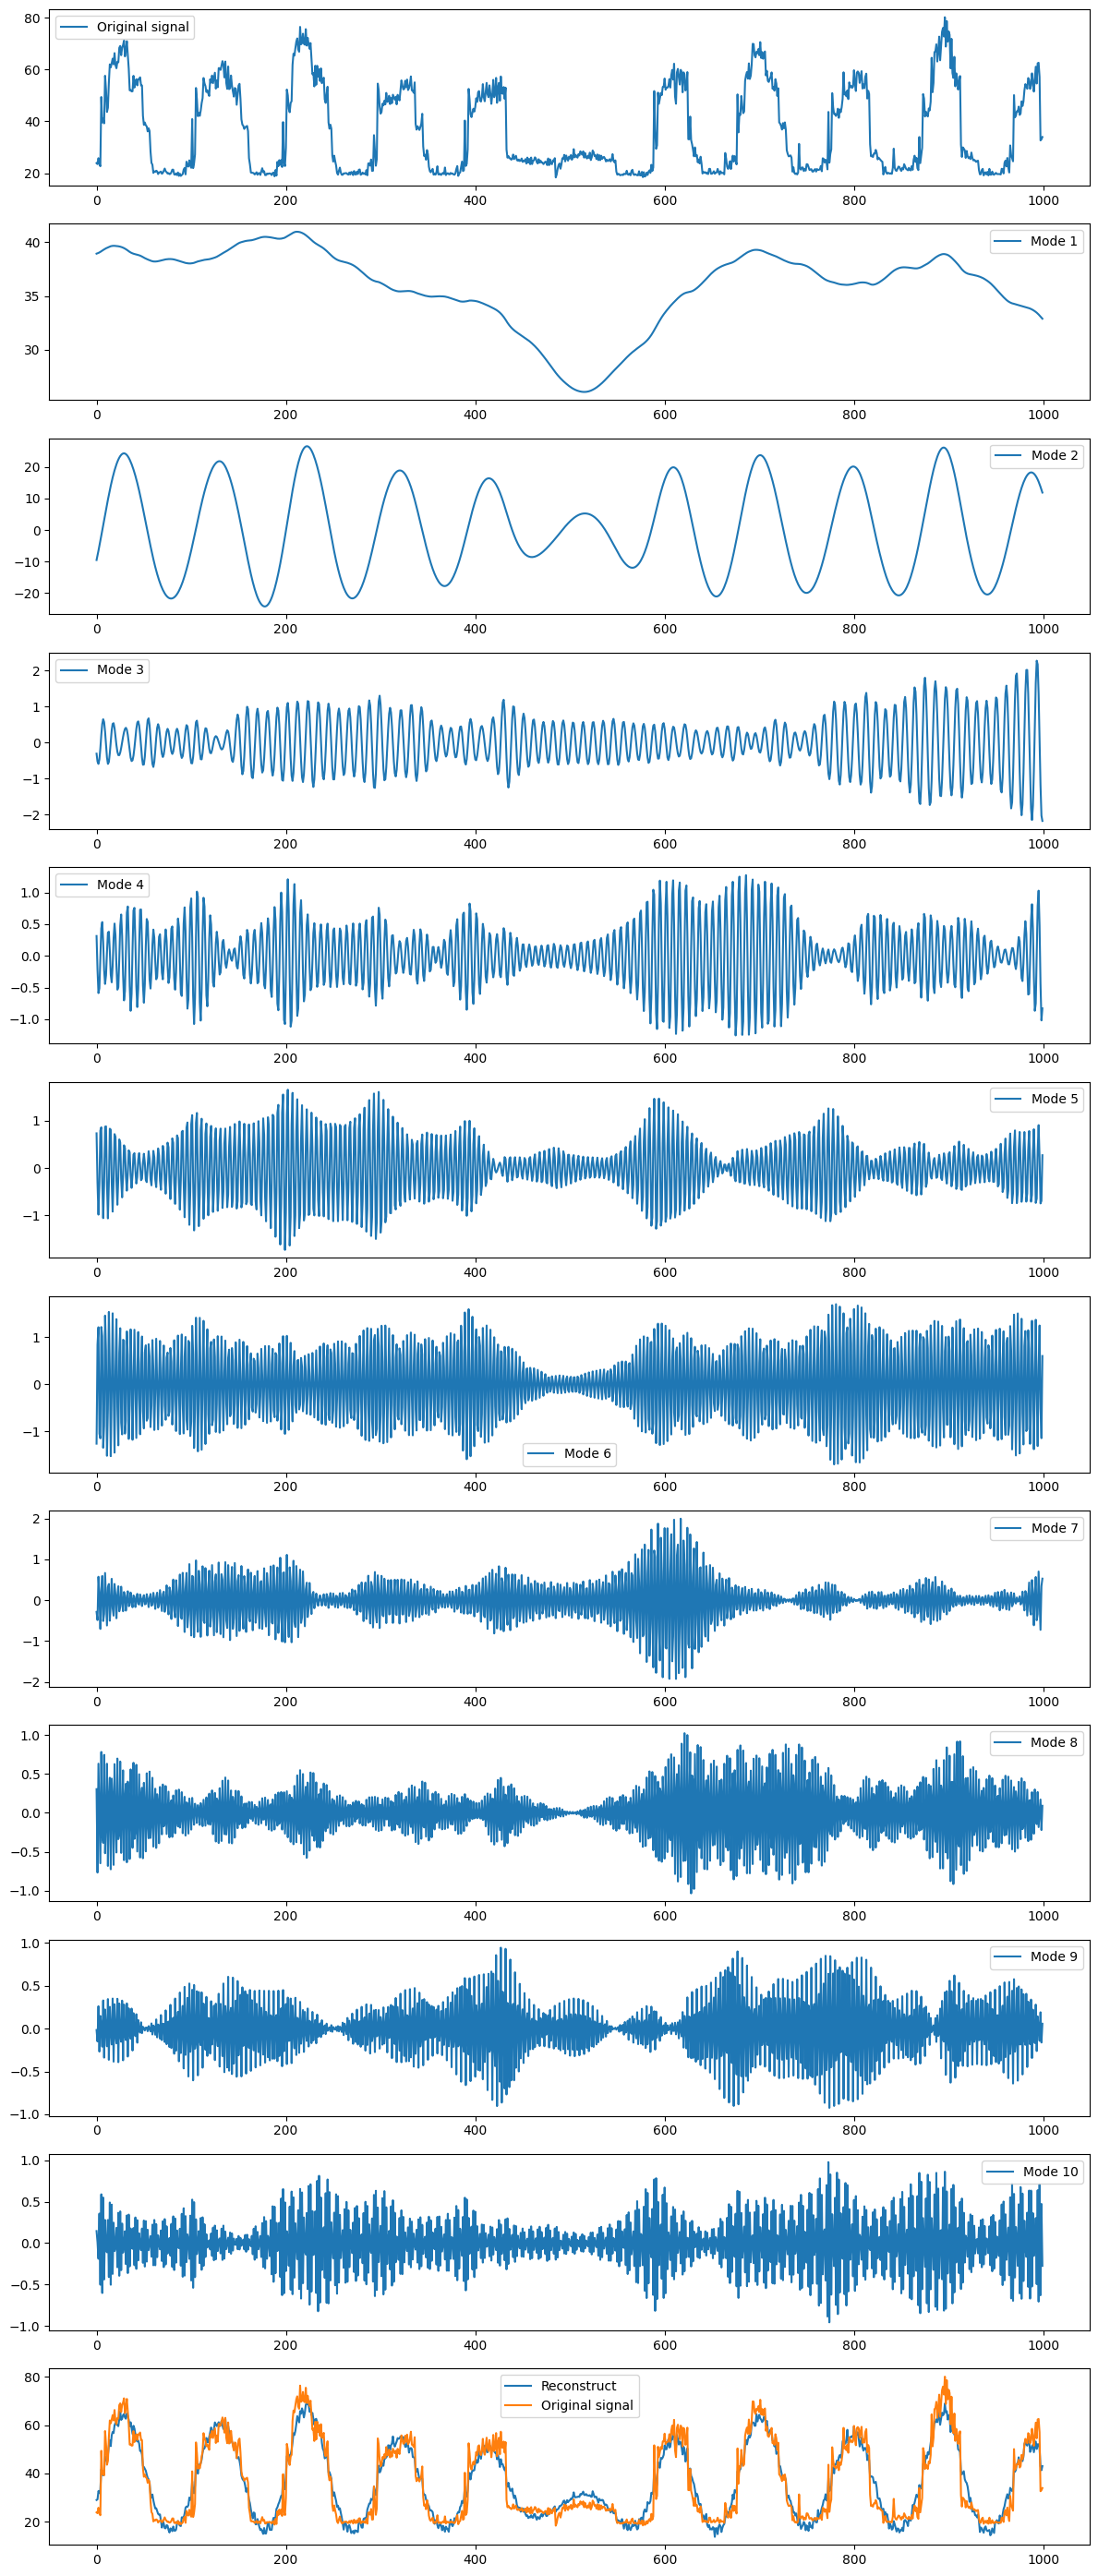

In [12]:
u, u_hat, omega = VMD(
    f=data['Load'].to_numpy(),
    alpha=len(data['Load']),
    tau=0,
    K=10,
    DC=0,
    init=1,
    tol=1e-6
)

print(u.shape)

t = np.arange(0, 1000)

plt.figure(figsize=(12, 28))
plt.subplot(len(u)+2, 1, 1)
plt.plot(t, data['Load'][15000:16000], label='Original signal')
plt.legend()

for i in range(len(u)):
    plt.subplot(len(u)+2, 1, i+2)
    plt.plot(t, u[i, 15000:16000], label=f'Mode {i+1}')
    plt.legend()

plt.subplot(len(u)+2, 1, len(u)+2)
plt.plot(t, np.sum(u, axis=0)[15000:16000], label='Reconstruct')
plt.plot(t, data['Load'][15000:16000], label='Original signal')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define a function to generate a list of timestamps every 2 hours within the dataset's range
def generate_timestamps(data) -> pd.DatetimeIndex:
    start = data['Timestamp'].min() + DateOffset(days=3)
    end = data['Timestamp'].max() - DateOffset(hours=2, minutes=30)
    timestamps = pd.date_range(start=start, end=end, freq='15min')
    return timestamps


In [ ]:
timestamps = generate_timestamps(data)
print(timestamps.shape)

In [ ]:
def generate_sets_for_all_timestamps(timestamps, data):
    training_sets = []
    change_rate_sets = []
    target_sets = []
    training_sets_time = []
    target_sets_time = []

    for timestamp in timestamps:
        # Calculate the range for the current period's data
        start_time_current = timestamp - DateOffset(days=2, hours=23, minutes=45)
        end_time_current = timestamp

        # Calculate the equivalent timestamp for last week
        # timestamp_last_week = timestamp - DateOffset(days=7)
        # start_time_last_week = timestamp_last_week - DateOffset(days=0, hours=23, minutes=45)
        # end_time_last_week = timestamp_last_week

        # Calculate the target range (the next 10 steps after the current timestamp)
        target_start_time = timestamp + DateOffset(minutes=15)
        target_end_time = timestamp + DateOffset(hours=2, minutes=30) 

        # Filter the data for training and target sets
        current_data = data[(data['Timestamp'] >= start_time_current) & (data['Timestamp'] <= end_time_current)]
        # last_week_data = data[(data['Timestamp'] >= start_time_last_week) & (data['Timestamp'] <= end_time_last_week)]
        target_data = data[(data['Timestamp'] >= target_start_time) & (data['Timestamp'] <= target_end_time)]

        # Combine current and last week data for the training set
        training_data = pd.concat([current_data]).reset_index(drop=True)
        
        # Save the training and target sets
        if not training_data.empty and not target_data.empty:
            training_sets.append(training_data['Load'])
            target_sets.append(target_data['Load'])
            training_sets_time.append(list(training_data['Timestamp']))
            target_sets_time.append(list(target_data['Timestamp']))

    training_sets = np.array(training_sets)
    target_sets = np.array(target_sets)
    training_sets_time = np.array(training_sets_time)
    target_sets_time = np.array(target_sets_time)

    return training_sets, target_sets, training_sets_time, target_sets_time


In [ ]:
# Generate training and target sets for all the timestamps
training_sets, target_sets, training_sets_time, target_sets_time = generate_sets_for_all_timestamps(timestamps, data)

In [ ]:
MONTH_TIME_STEP = math.floor(timestamps.shape[0] / 24)
X_test = []
y_test = []
X_test_time = []
y_test_time = []
minList = []
maxList = []
for i in range(0, 24):
    start = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    end = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test.append(training_sets[start:end])
    y_test.append(target_sets[start:end])
    X_test_time.append(training_sets_time[start:end])
    y_test_time.append(target_sets_time[start:end])
    training_sets = np.concatenate([training_sets[:start], training_sets[end:]])
    target_sets = np.concatenate([target_sets[:start], target_sets[end:]])
    training_sets_time = np.concatenate([training_sets_time[:start], training_sets_time[end:]])
    target_sets_time = np.concatenate([target_sets_time[:start], target_sets_time[end:]])


In [ ]:
X_test = np.concatenate([i for i in X_test])
y_test = np.concatenate([i for i in y_test])
X_test_time = np.concatenate([i for i in X_test_time])
y_test_time = np.concatenate([i for i in y_test_time])

In [ ]:
X_train = training_sets.reshape(training_sets.shape[0], training_sets.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = target_sets
X_train_time = training_sets_time
y_train_time = target_sets_time


In [ ]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)


In [ ]:
def create_model(input_shape, num_ouputs):
    return